In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables

from lstchain.io.io import dl1_params_lstcam_key

from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from ctapipe.image import tailcuts_clean
from lstchain.calib.camera.utils import get_threshold_from_dl1_file

geom = CameraGeometry.from_name('LSTCam-002')

In [2]:
def get_pedestal_images(dl1_filename):
    trigger_source='ucts_trigger_type'
    f = tables.open_file(dl1_filename)
    parameters = pd.read_hdf(dl1_filename, key=dl1_params_lstcam_key)
    image_table = f.root.dl1.event.telescope.image.LST_LSTCam
    params_pedestal_mask = (parameters[trigger_source] == 32)
    ped_indices = np.array(parameters['event_id'][params_pedestal_mask])
    pedestal_mask = (parameters[trigger_source] == 32)
    ped_image =  image_table.col('image')[pedestal_mask]
    f.close()
    return ped_image

def make_image_plot(img, img_cleaned):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    disp0 = CameraDisplay(geom, ax=ax[0])
    disp0.image = img
    disp0.add_colorbar(ax=ax[0], label="signal [p.e.]")
    disp0.cmap = 'gnuplot2'
    ax[0].set_title("Dl1 image", fontsize=20)
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    
    disp1 = CameraDisplay(geom, ax=ax[1])
    disp1.image = img_cleaned
    disp1.add_colorbar(ax=ax[1], label="signal [p.e.]")
    disp1.cmap = 'gnuplot2'
    ax[1].set_title("Dl1 cleaned image", fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

In [3]:
path_3004 =  "/media/pawel1/ADATA HD330/20201122/DL1/v0.6.3_v05/dl1_LST-1.Run03004.0000.h5"
path_to_dl1_data = path_3004
ped_images = get_pedestal_images(path_to_dl1_data)

0


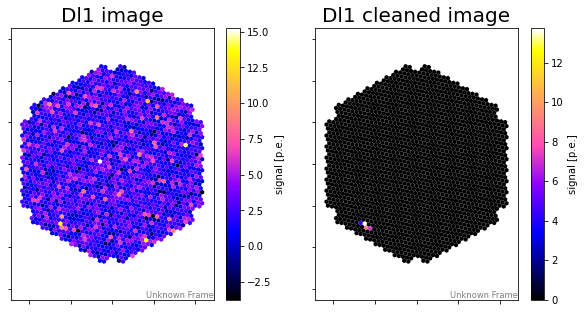

1


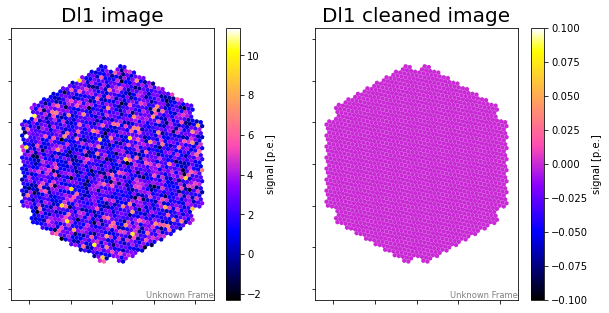

2


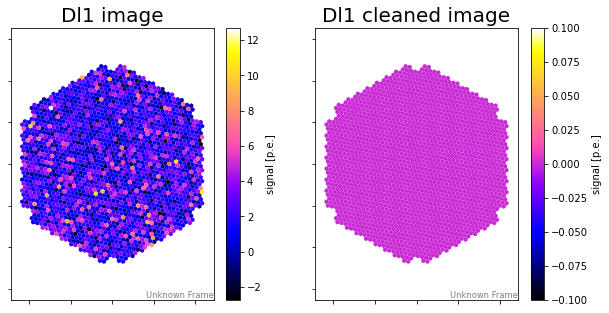

3


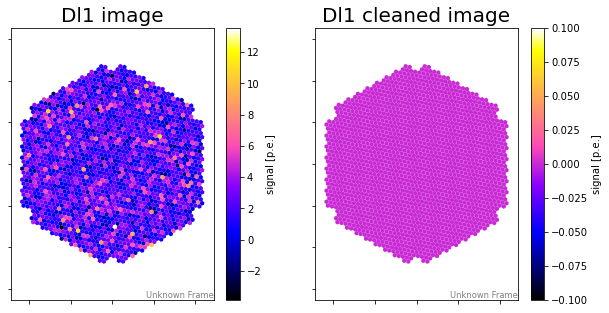

4


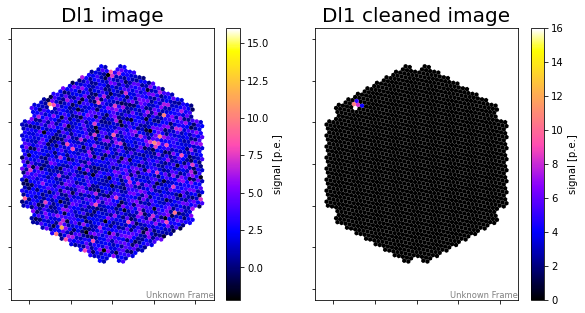

5


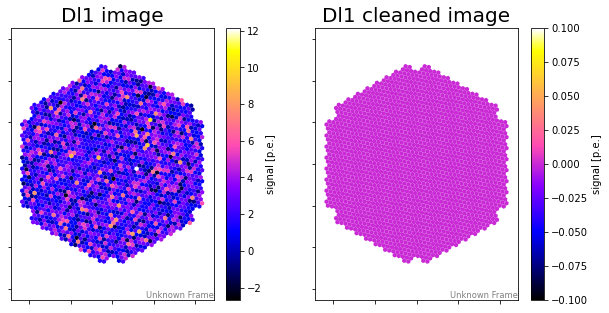

6


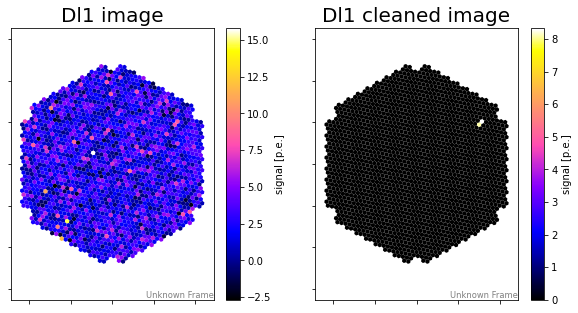

7


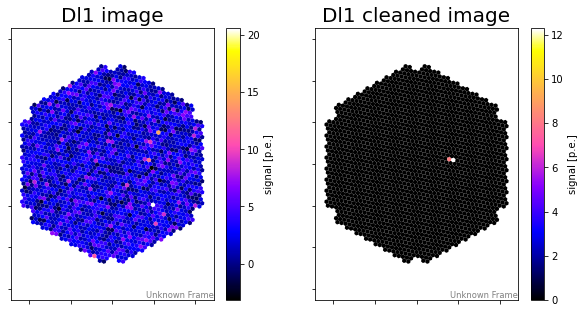

8


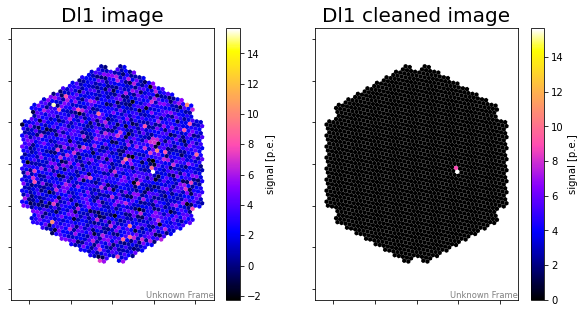

9


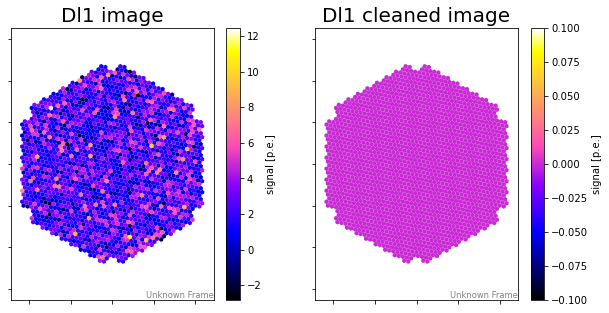

10


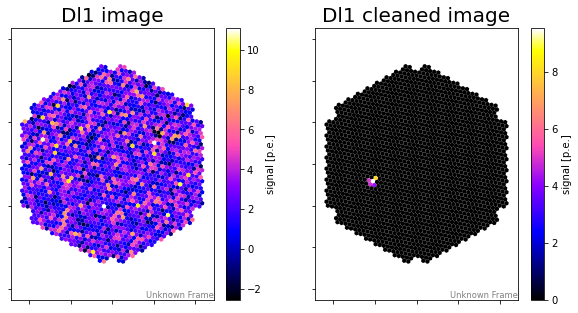

11


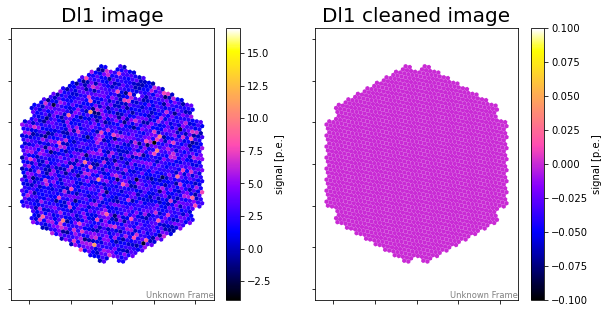

12


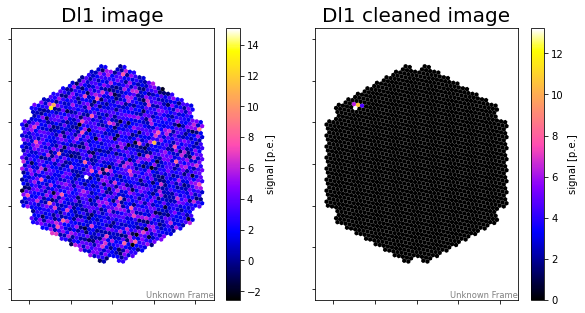

13


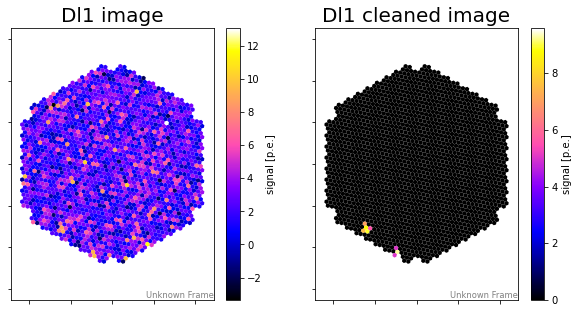

14


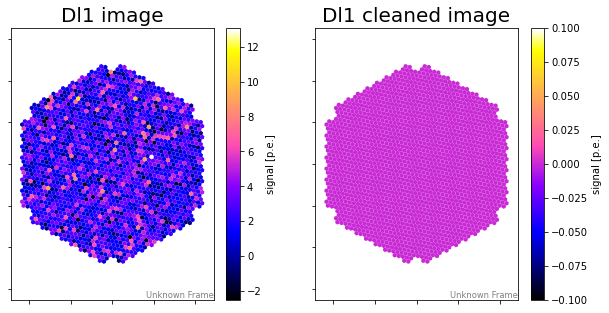

In [4]:
pic_th = 8
bound_th = 4
geom = CameraGeometry.from_name('LSTCam-002')
for i, image in enumerate(ped_images[:15]):
    print(i)
    img = image.copy()
    clean = tailcuts_clean(
                       geom,
                       img,
                       picture_thresh=pic_th,
                       boundary_thresh=bound_th,
                       keep_isolated_pixels=False,
                       min_number_picture_neighbors=1,
                      )
    cleaned = img.copy()
    cleaned[~clean] = 0.0
    make_image_plot(img, cleaned)
    plt.show()

# Modified cleaning method: picture threshold calculated with interleaved pedestal
* Pedestal calculated using interleaved events.
* Modified picture threshold for tailcut cleaning method.
* Cleaning the most noisy pixels (for example around the star location), for rest pixels picture threshold doesn't change.

Threshold for each pixel is define as: ***threshold = pedestal_bias + sigma***$\cdot$***pedestal_std*** 

***sigma - parameter to set***


Recommended threshold for cleaning:
* galactic source: picture_thresh=8, boundary_thresh=4, sigma=3
* extragalactic source: picture_thresh=6, boundary_thresh=3, sigma=2.5

0


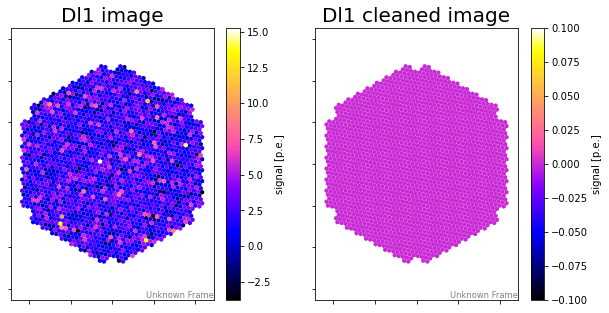

1


In [ ]:
pic_th = 8
bound_th = 4
sigma = 3
th_ped_interleave = get_threshold_from_dl1_file(path_to_dl1_data, sigma)
pedestal_threshhold = th_ped_interleave
picture_thresh = np.clip(pedestal_threshhold, pic_th, None)

geom = CameraGeometry.from_name('LSTCam-002')
for i, image in enumerate(ped_images[:15]):
    print(i)
    img = image.copy()
    clean = tailcuts_clean(
                       geom,
                       img,
                       picture_thresh=picture_thresh,
                       boundary_thresh=bound_th,
                       keep_isolated_pixels=False,
                       min_number_picture_neighbors=1,
                      )
    cleaned = img.copy()
    cleaned[~clean] = 0.0
    make_image_plot(img, cleaned)
    plt.show()

# Threshold signal map

Text(0.5, 1.0, 'Threshold from pedestal')

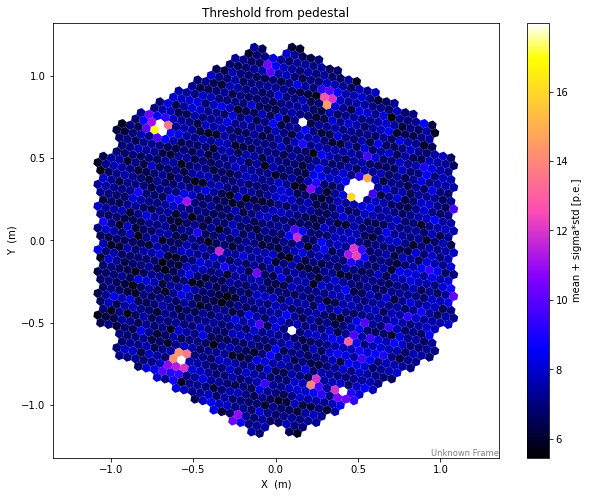

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
disp0 = CameraDisplay(geom, ax=ax)
disp0.image = th_ped_interleave
disp0.add_colorbar(ax=ax, label="mean + sigma*std [p.e.]")
disp0.cmap = 'gnuplot2'
ax.set_title("Threshold from pedestal")